# MDM-TASK-web command line tools

## Quick introduction

The tools mine information about protein dynamics. Most tools require a topology file and a molecular dynamics trajectory (but not always). Documentation for the command line tools is obtained likewise:

`../calc_correlation.py -h`. 

This notebook gives a short overview of how the command line tools can be used. The <strong>MDM-TASK-web</strong> is available <a href="https://mdmtaskweb.rubi.ru.ac.za/">here</a>

In [1]:
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Dynamic Cross Correlation

DCC determines the pairwise correlation of residue motion across an MD trajectory, using C-alpha atoms by default. It is also possible to use one or more atom types (as found in the topology file), via a comma-separated list of atoms (without spaces) to use for DCC calculation. E.g. 'CA,P'. The backbone phosphorus 'P' atom can be a good choice for representing nucleotide residues. In the resulting plot, residue indices are numbered starting from zero.

INFO::Using Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
INFO::Started at: 2021-09-12 01:05:28.321160
INFO::Preparing a trajectory matrix...
INFO::Correlating...
INFO::Plotting heat map...
INFO::Completed at: 2021-09-12 01:05:30.556302
INFO::- Total time: 0:00:02


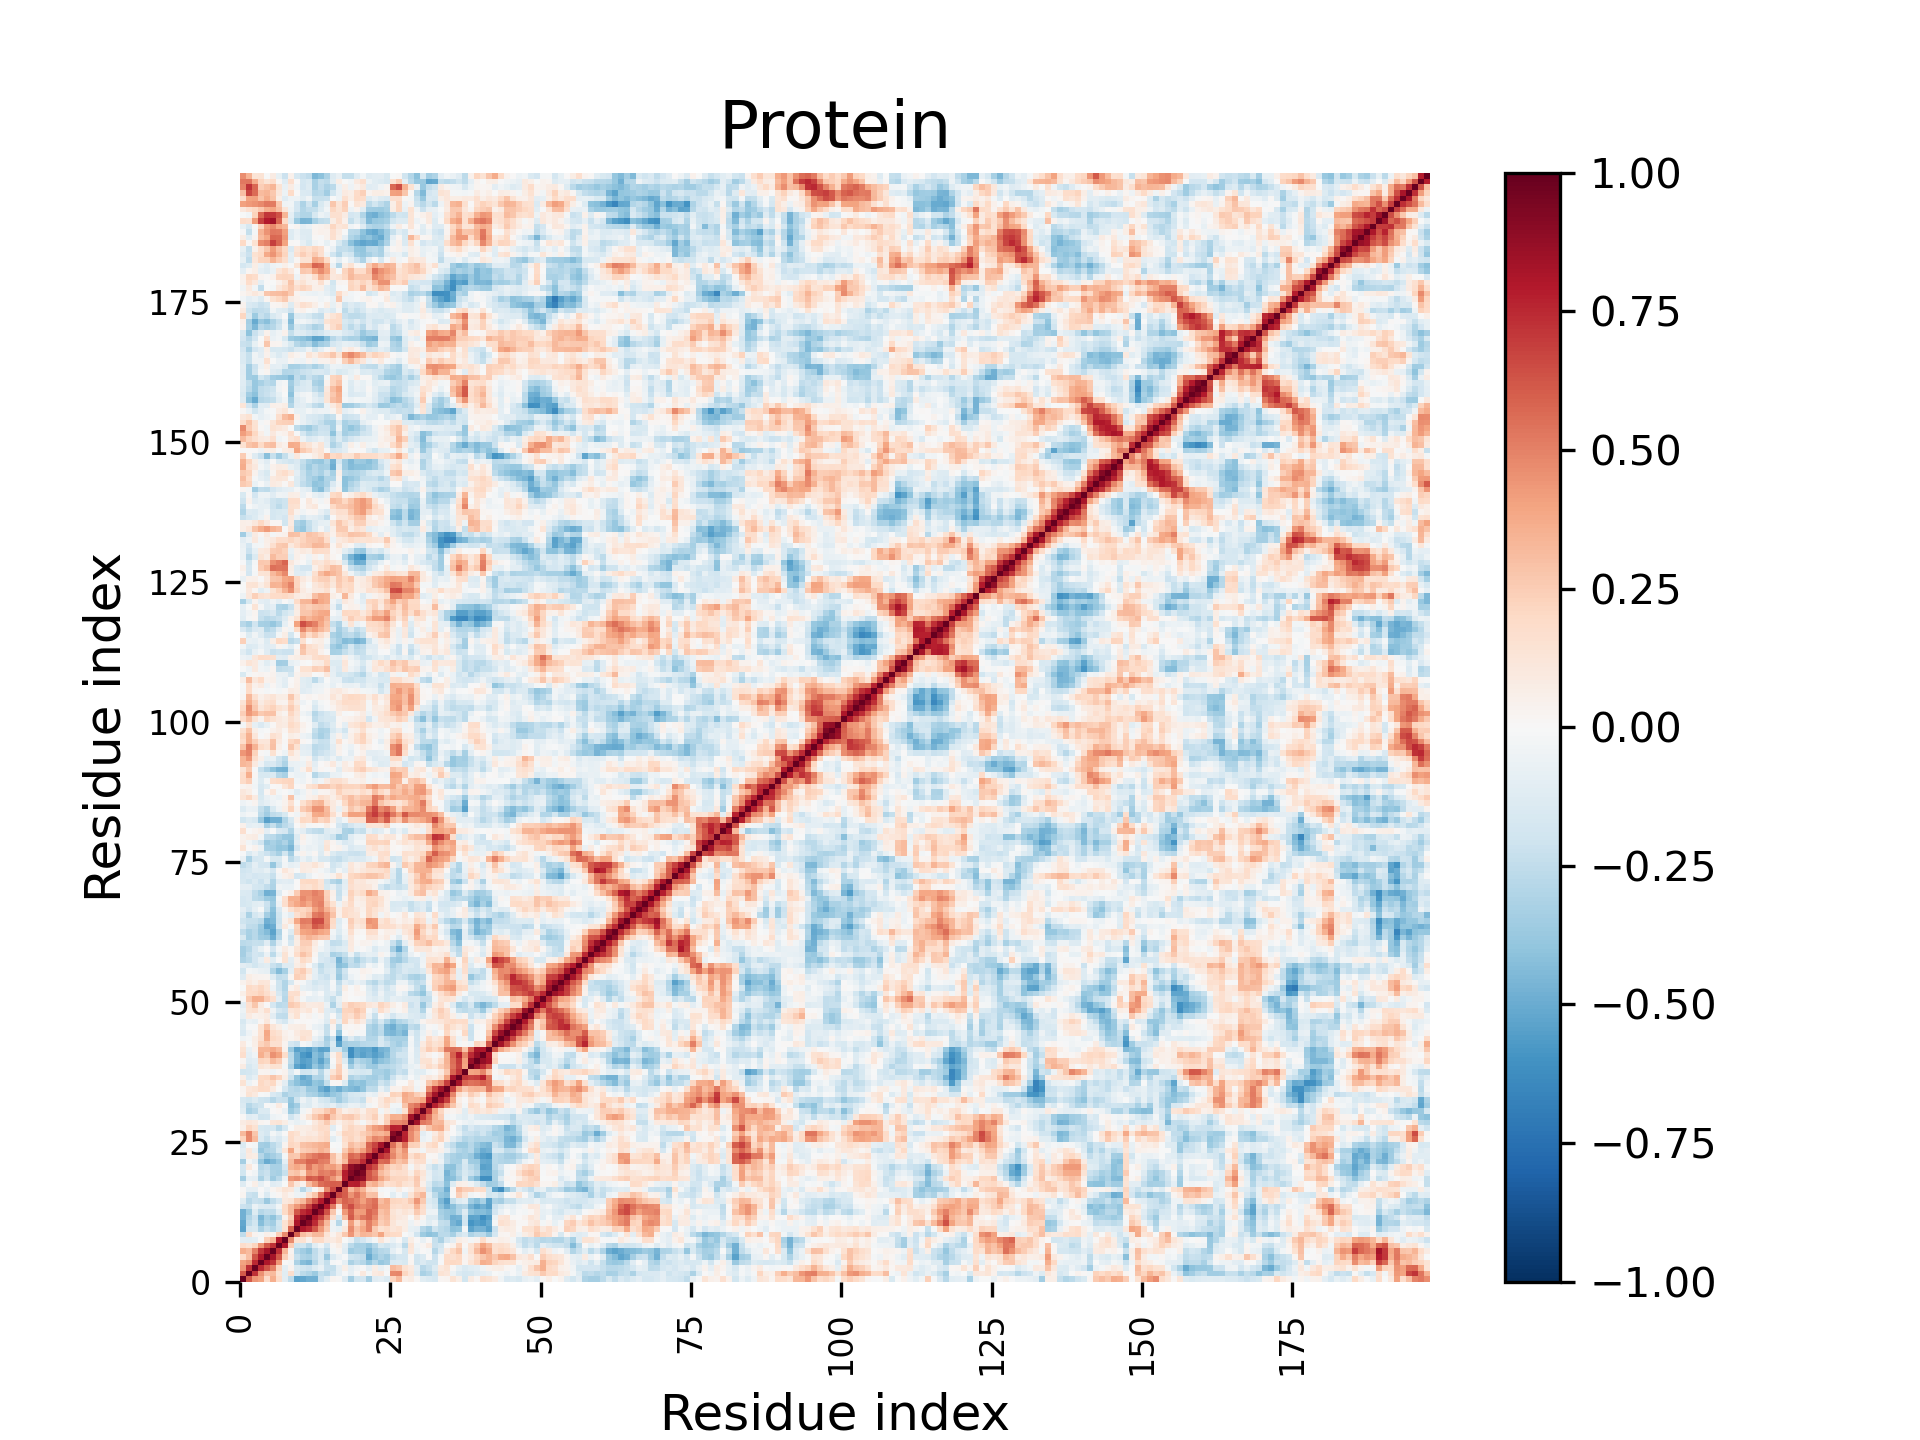

In [2]:
!../src/calc_correlation.py --step 50 --topology ../data/pr1.pdb ../data/pr1.xtc
Image("correlation.png")

## Residue Interaction Network analysis

Network centrality metrics from a residue interaction network (RIN) are calculated from a single conformation (provided in any MDTraj-supported format). Each graph consists of nodes (protein C-beta, or GLY C-alpha atoms) connected by edges (binary: 0, 1) that are assigned using a user-defined cut-off distance for each protein residue pair. The default cut-off distance of 6.7 Angstroms comes from previous work identifying the first of a series of coordination shells using the radial distribution function in a collection of proteins

In [3]:
!../src/calc_network.py --topology ../data/pr2.pdb --calc-BC ../data/pr2.pdb
v = nv.show_file("./pr2_mean_BC.cif")
v.clear_representations()
v.add_representation("spacefill", colorScheme="bfactor")
v.center()
v

INFO::Started at: 2021-09-12 01:05:43.289011
/home/olivier/bin/anaconda/envs/py38/lib/python3.8/site-packages/mdtraj/core/trajectory.py:422: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')
INFO::Calculating centralities...
INFO::Saved DRN metrics as pr2_*.csv.
/home/olivier/bin/anaconda/envs/py38/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 205
  warnings.warn(
INFO::Wrote DRN statistic as B-factor in pr2_mean_BC.cif
INFO::Completed at: 2021-09-12 01:05:43.768328
INFO::- Total time: 0:00:00


NGLWidget()

## Dynamic Residue Network analysis

Dynamic Residue Network analysis is calculated from the aggregation of metrics computed from network graphs, which are themselves computed over each frame from a conformational sampling experiment, typically MD. Each graph consists of nodes (protein C-beta, or GLY C-alpha atoms) connected by edges that are assigned using a user-defined cut-off distance for each protein residue pair. The default cut-off distance of 6.7 Angstroms comes from previous work identifying the first of a series of coordination shells using the radial distribution function in a collection of proteins. This value can be changed if desired, for experimentation.
For faster uploads we recommend reducing the input trajectory.

In [4]:
!../src/calc_network.py --topology ../data/pr1.pdb --step 50 --calc-BC ../data/pr1.xtc
v = nv.show_file("./pr1_mean_BC.cif")
v.clear_representations()
v.add_representation("spacefill", colorScheme="bfactor")
v.center()
v

INFO::Started at: 2021-09-12 01:05:49.340786
INFO::Calculating centralities...
INFO::Saved DRN metrics as pr1_*.csv.
/home/olivier/bin/anaconda/envs/py38/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 205
  warnings.warn(
INFO::Wrote DRN statistic as B-factor in pr1_mean_BC.cif
INFO::Completed at: 2021-09-12 01:05:52.288332
INFO::- Total time: 0:00:02


NGLWidget()

### Examining the data using the Pandas library

In [8]:
pd.read_csv("./pr2_mean.csv").head(2)

,BC,CC,DC,EC,ECC,L,PR,katz
0,0.001575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000863,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting of DRN results

<AxesSubplot:>

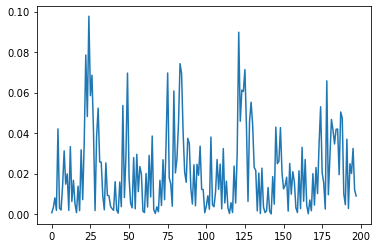

In [11]:
pr1 = pd.read_csv("./pr2_mean.csv")
pr1.BC.plot()

### Comparing DRN results for two samples using delta calculations

Perform two DRN runs

In [9]:
!../src/calc_network.py --topology ../data/pr2.pdb --step 50 --calc-BC ../data/pr2.xtc
!../src/calc_network.py --topology ../data/pr3.pdb --step 50 --calc-BC ../data/pr3.xtc

INFO::Started at: 2021-09-12 01:09:19.935187
INFO::Calculating centralities...
INFO::Saved DRN metrics as pr2_*.csv.
/home/olivier/bin/anaconda/envs/py38/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 205
  warnings.warn(
INFO::Wrote DRN statistic as B-factor in pr2_mean_BC.cif
INFO::Completed at: 2021-09-12 01:09:22.752763
INFO::- Total time: 0:00:02
INFO::Started at: 2021-09-12 01:09:23.714937
INFO::Calculating centralities...
INFO::Saved DRN metrics as pr3_*.csv.
/home/olivier/bin/anaconda/envs/py38/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 205
  warnings.warn(
INFO::Wrote DRN statistic as B-factor in pr3_mean_BC.cif
INFO::Completed at: 2021-09-12 01:09:26.840785
INFO::- Total time: 0:00:03


<AxesSubplot:>

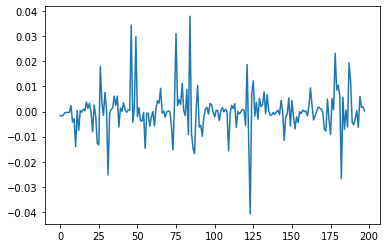

In [16]:
pr2 = pd.read_csv("./pr2_mean.csv")
pr3 = pd.read_csv("./pr3_mean.csv")
delta = pr2.BC - pr3.BC
delta.plot()

# Weighted Residue Contact Map

Generate a weighted network graph using contact frequencies obtained at a defined cut-off radius (typically 6.7) around a protein residue of interest. It can be very useful in getting a weighted contact graph at residue locus of high centrality determined from the DRN metrics. The edge weights represent the contact frequencies determined over the course of the trajectory. It can be coupled to the contact heat map tool for large scale comparisons.

In [ ]:
!../src/contact_map.py --topology ../data/pr1.pdb --step 10 --residue ASH25 --ocsv ASH25_pr1.csv ../data/pr1.xtc
Image("ASH25_chainA_contact_map.png")

In [ ]:
%%bash
../src/contact_map.py --topology ../data/pr2.pdb --step 10 --residue ASH25 --ocsv ASH25_pr2.csv ../data/pr2.xtc
../src/contact_map.py --topology ../data/pr3.pdb --step 10 --residue ASH25 --ocsv ASH25_pr3.csv ../data/pr3.xtc
../src/contact_map.py --topology ../data/pr4.pdb --step 10 --residue ASH25 --ocsv ASH25_pr4.csv ../data/pr4.xtc
../src/contact_map.py --topology ../data/pr5.pdb --step 10 --residue ASH25 --ocsv ASH25_pr5.csv ../data/pr5.xtc
../src/contact_map.py --topology ../data/pr6.pdb --step 10 --residue ASH25 --ocsv ASH25_pr6.csv ../data/pr6.xtc
../src/contact_map.py --topology ../data/pr7.pdb --step 10 --residue ASH25 --ocsv ASH25_pr7.csv ../data/pr7.xtc

## Weighted Residue Contact Heatmap

The contact heatmap aggregates the CSV files obtained from multiple weighted contact network graphs. This enables high-throughput comparison of the local neighborhoods of a given residue position across comparable samples. For example, a given position can be compared in the presence and absence of a drug. The position of interest may not necessarily be the site of a missense mutation, but can be a useful follow-up method to, for example examine the results of degree centrality mapping in greater detail across multiple mutants or various experimental conditions.

In [ ]:
!../src/contact_heatmap.py --annotate --xtickfontsize 8 ASH25_pr*.csv
Image("contact_heatmap.png")

## Perturbation response scanning

PRS sequentially applies a set of uniformly distributed forces (Perturbations) to each residue from an initial (reference) conformation before assesing the correlation against a target (final) conformation. The final conformation needs tot be identical to the input topology, but only needs have be homologous residues. For proper representativeness, it is important that the trajectory used for the calculation of the covariance matrix be properly equilibrated.

### Getting the target conformation

Let's download an opened conformation HIV protease structure as our <strong>target conformation</strong> from the PDB

In [ ]:
!wget -O ../data/1TW7.pdb https://files.rcsb.org/download/1TW7.pdb 

In [ ]:
nv.show_file('../data/1TW7.pdb')

### Our initial conformation/ topology

In [ ]:
nv.show_file('../data/pr1.pdb')

In [ ]:
!../src/prs.py --topology ../data/pr1.pdb --perturbations 30 --step 1 --final ../data/1TW7.pdb ../data/pr1.xtc 

### Custom plotting of PRS correlation data

In [ ]:
pd.read_csv("result.csv").plot()